# Bonus certificate calculation

INTEL


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import yfinance as yf
from FFTpricing import ModelCalibrator

# Get Market Data

## Interest Term Structure

In [2]:
# from pandas_datareader import data as pdr
# import datetime

# All US Treasury maturities (3M, 6M, 1Y, 2Y, 3Y, 5Y, 7Y, 10Y, 20Y, 30Y)
T_list = pd.Series([3/12,6/12,1,2,3,5,7,10,20,30])
# fred_tickers = [
#     "DGS3MO", "DGS6MO", "DGS1", "DGS2", "DGS3", 
#     "DGS5", "DGS7", "DGS10", "DGS20", "DGS30"
# ]

# yields.to_parquet('yields.parquet')
yields = pd.read_parquet('yields.parquet')

# start = datetime.datetime.now() - datetime.timedelta(days=30)
# yields = pdr.DataReader(fred_tickers, "fred", start).dropna()
print(yields.tail())

            DGS3MO  DGS6MO  DGS1  DGS2  DGS3  DGS5  DGS7  DGS10  DGS20  DGS30
DATE                                                                         
2025-05-06    4.33    4.25  3.98  3.78  3.73  3.90  4.10   4.30   4.82   4.81
2025-05-07    4.34    4.27  4.00  3.78  3.72  3.87  4.06   4.26   4.78   4.77
2025-05-08    4.34    4.28  4.05  3.90  3.85  4.00  4.18   4.37   4.86   4.83
2025-05-09    4.34    4.28  4.05  3.88  3.85  4.00  4.18   4.37   4.86   4.83
2025-05-12    4.42    4.29  4.11  3.98  3.97  4.09  4.27   4.45   4.92   4.89


In [3]:
r_term = pd.concat([np.round(yields.iloc[-1].reset_index(drop=True)/100,6),T_list], axis=1)
r_term.columns = ['r','T']
r_term['r'] = 0.0411

## Dividend yield term structure

In [4]:
q_term = r_term.copy()
q_term.columns = ['q','T']
q_term['q'] = 0.0

## Vanilla Options Data

In [5]:
S0=21.6

In [6]:
# ticker = 'INTC'
# stock = yf.Ticker(ticker)

# exp_dates = stock.options

# import pickle

# # Save
# with open('exp_dates_INTC.pkl', 'wb') as f:
#     pickle.dump(exp_dates, f)

# # Load
# with open('exp_dates_INTC.pkl', 'rb') as f:
#     exp_dates = pickle.load(f)


# # Initialize empty dataframes for calls and puts
# all_calls = pd.DataFrame()
# all_puts = pd.DataFrame()

# for date in exp_dates:
#     try:
#         opt = stock.option_chain(date)
#         opt.calls['expiration'] = date
#         opt.puts['expiration'] = date
        
#         all_calls = pd.concat([all_calls, opt.calls])
#         all_puts = pd.concat([all_puts, opt.puts])
#     except Exception as e:
#         print(f"Error with {date}: {e}")

# all_calls.to_parquet('calls_INTC.parquet')
# all_puts.to_parquet('puts_INTC.parquet')

all_calls = pd.read_parquet('calls_INTC.parquet')
all_puts = pd.read_parquet('puts_INTC.parquet')

In [7]:
from DataPrep import cleanup, add_T, build_calibration_triangle

In [8]:
add_T(all_calls, '2025-05-14')
add_T(all_puts, '2025-05-14')
all_calls = all_calls.rename(columns={"strike": "K"})
all_puts = all_puts.rename(columns={"strike": "K"})
all_calls['calls'] = (all_calls['bid'] + all_calls['ask'])/2
all_puts['puts'] = (all_puts['bid'] + all_puts['ask'])/2

all_cals_clean = cleanup(all_calls)

# all_cals_clean['calls'] = (all_cals_clean['bid'] + all_cals_clean['ask'])/2
all_cals_clean = all_cals_clean[all_cals_clean['T']>5/365].copy()

all_puts_clean = cleanup(all_puts)
# all_puts_clean['puts'] = (all_puts_clean['bid'] + all_puts_clean['ask'])/2
all_puts_clean = all_puts_clean[all_puts_clean['T']>5/365].copy()

# all_cals_clean_triangle = build_calibration_triangle(all_cals_clean, S0, a=0.08, b=-1.2, c=0.05)
# all_puts_clean_triangle = build_calibration_triangle(all_puts_clean, S0, a=0.08, b=-1.2, c=0.05)

all_cals_clean['ask/bid'] = all_cals_clean['ask']/all_cals_clean['bid']-1
all_cals_clean = all_cals_clean[all_cals_clean['ask/bid']<=all_cals_clean['ask/bid'].quantile(0.9)].copy()

all_puts_clean['ask/bid'] = all_puts_clean['ask']/all_puts_clean['bid']-1
all_puts_clean = all_puts_clean[all_puts_clean['ask/bid']<=all_puts_clean['ask/bid'].quantile(0.9)].copy()


more = 0.02
all_cals_clean= all_cals_clean[all_cals_clean['K']>=S0*(1-more)].copy()
all_puts_clean= all_puts_clean[all_puts_clean['K']<S0*(1+more)].copy()

Maturity converted to years
Maturity converted to years


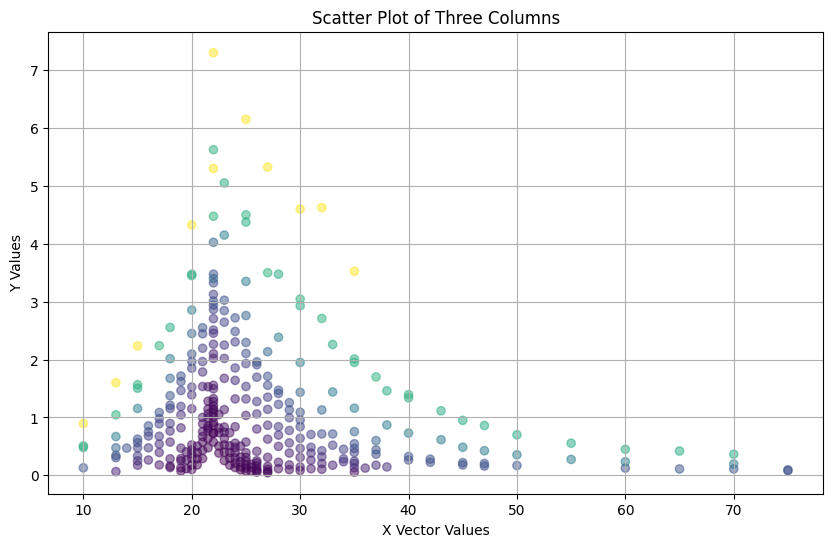

In [9]:
plt.figure(figsize=(10, 6))

all_cals_clean_exp = all_cals_clean[all_cals_clean['T']<=10]
all_puts_clean_exp = all_puts_clean[all_puts_clean['T']<=10]

plt.scatter(all_cals_clean_exp['K'], all_cals_clean_exp['calls'], alpha=0.5, marker='o', c=all_cals_clean_exp['T'], cmap='viridis')
plt.scatter(all_puts_clean_exp['K'], all_puts_clean_exp['puts'], alpha=0.5, marker='o', c=all_puts_clean_exp['T'], cmap='viridis')

# Add labels and legend
plt.xlabel('X Vector Values')
plt.ylabel('Y Values')
plt.title('Scatter Plot of Three Columns')

plt.grid(True)
plt.show()

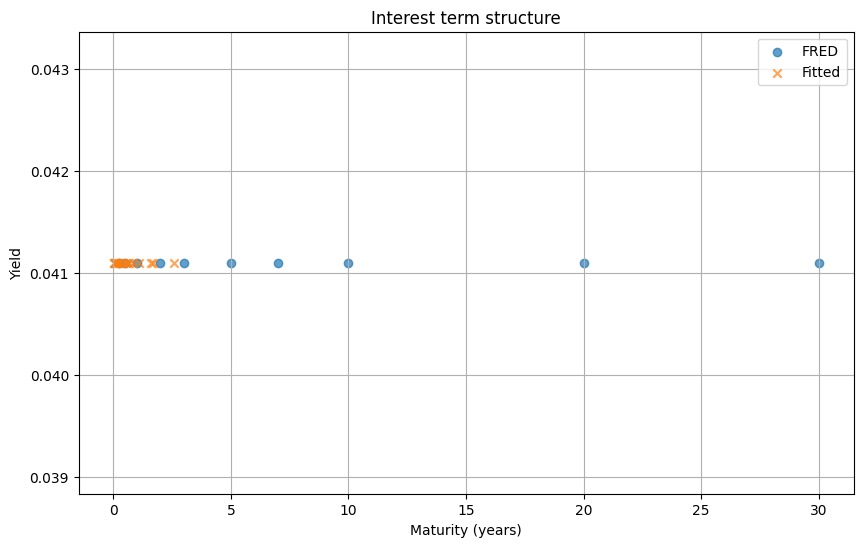

In [10]:
plt.figure(figsize=(10, 6))

r_interp = interp1d(r_term['T'], r_term['r'], kind='cubic', fill_value="extrapolate")
plt.scatter(r_term['T'], r_term['r'], alpha=0.7, marker='o', label='FRED')
plt.scatter(all_puts_clean['T'].unique(),r_interp(all_puts_clean['T'].unique()), alpha=0.7, marker='x', label='Fitted')

# Add labels and legend
plt.xlabel('Maturity (years)')
plt.ylabel('Yield')
plt.title('Interest term structure')
plt.legend()

plt.grid(True)
plt.show()

# Callibrate Vanilla Model

In [ ]:
params_BATES = {'kappa':0.4963,
                'theta':0.065,
                'sigma_v':0.2286,
                'rho': - 0.99,
                'v0': 0.0576,
                'lambda': 0.1382,
                'muJ': 0.1791,
                'sigmaJ': 0.1346}

params_BATES = {'kappa': 0.38674,
                'theta': 0.37644,
                'sigma_v': 1.1403,
                'rho': -0.3749,
                'v0': 0.1362,
                'lambda': 2.1467,
                'muJ': 0.1483,
                'sigmaJ': 0.1300}

In [26]:
modcab = ModelCalibrator('BATES', S0, r_term, q_term,  all_cals_clean, all_puts_clean, params_BATES)

bounds_BATES = {'kappa': (0.01,10),
                'theta':(0.01,1),
                'sigma_v': (0.01,2),
                'rho': (-0.999, 0.999),
                'v0': (0.01,1),
                'lambda': (0,10),
                'muJ': (-1,1),
                'sigmaJ': (0.01,0.5)}

modcab.set_bounds(bounds_BATES)
positive_only = ['kappa', 'theta', 'sigma_v', 'v0', 'sigmaJ']

sortedcalls= all_cals_clean.sort_values(['K','T'])
sortedputs= all_puts_clean.sort_values(['K','T'])

weight = np.concatenate([sortedcalls['openInterest'].values,
                         sortedputs['openInterest'].values])
# weight_moneyness = np.concatenate([10*np.exp(-10*(S0/sortedcalls['K'].values-1)**2),
#                                    10*np.exp(-10*(S0/sortedputs['K'].values-1)**2)])

weight_moneyness = np.concatenate([10*np.exp(-6*np.abs(S0 - sortedcalls['K'].values)/(np.abs(S0) + np.abs(sortedcalls['K'].values))), 
                                   10*np.exp(-6*np.abs(S0 - sortedputs['K'].values)/(np.abs(S0) + np.abs(sortedputs['K'].values)))])

weight_T = np.concatenate([1*np.exp(-1*(sortedcalls['T'].values)**2),
                           1*np.exp(-1*(sortedputs['T'].values)**2)])

weight_mT = weight_moneyness*weight_T

modcab.calibrate(positive_only, weight_mT, 'LRMSE', 1e-3,  N=2**14, eta=0.25)

(  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
   success: True
    status: 0
       fun: 0.07989464834335774
         x: [-9.500e-01 -9.770e-01  1.313e-01 -3.749e-01 -1.993e+00
              2.147e+00  1.484e-01 -2.040e+00]
       nit: 65
       jac: [-9.606e-05  3.235e-05 -5.650e-05  2.102e-05 -1.854e-05
             -8.973e-05 -2.908e-04 -3.262e-05]
      nfev: 765
      njev: 85
  hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>,
 {'kappa': 0.3867454842145829,
  'theta': 0.3764498600792881,
  'sigma_v': 1.1403560261222816,
  'rho': -0.3749153963825807,
  'v0': 0.13626888427693623,
  'lambda': 2.1467029938989244,
  'muJ': 0.14835360083165006,
  'sigmaJ': 0.13007476911620464})

In [17]:
modcab.error_function()

0.011375738224937421

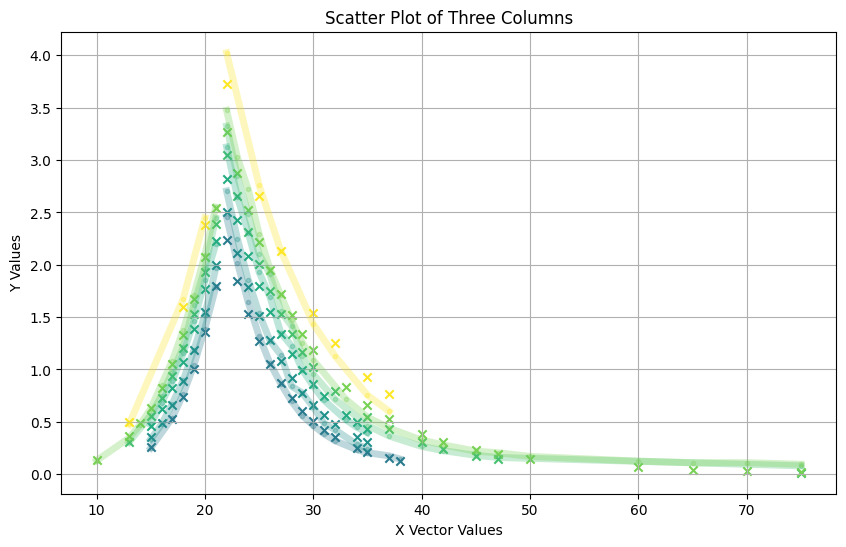

In [47]:
prices = modcab.calculate_prices(calls_data=all_cals_clean, puts_data=all_puts_clean)
prices['key'] = prices['K'].round(3).astype(str) + "_" + prices['T'].round(6).astype(str)
keys_calls = all_cals_clean['K'].round(3).astype(str) + "_" + all_cals_clean['T'].round(6).astype(str)
keys_puts = all_puts_clean['K'].round(3).astype(str) + "_" + all_puts_clean['T'].round(6).astype(str)

plt.figure(figsize=(10, 6))

uT = 1
lT = 0.3

all_cals_clean__plot = all_cals_clean[(all_cals_clean['T']<=uT) & (all_cals_clean['T']>=lT) & (all_cals_clean['K']>=(S0))]
all_puts_clean__plot = all_puts_clean[(all_puts_clean['T']<=uT) & (all_puts_clean['T']>=lT) & (all_puts_clean['K']<(S0))]
prices_calls = prices[(prices['T']<=uT) & (prices['T']>=lT) & (prices['key'].isin(keys_calls)) & (prices['K']>=(S0))]
prices_puts = prices[(prices['T']<=uT) & (prices['T']>=lT) & (prices['K']<(S0)) & (prices['key'].isin(keys_puts))]

# plt.scatter(prices_calls['K'], prices_calls['calls'], alpha=0.5, marker='x', c=plt.cm.viridis(all_cals_clean__plot['T'] / all_cals_clean__plot['T'].max())) #, cmap='viridis')
# plt.scatter(all_cals_clean__plot['K'], all_cals_clean__plot['calls'], alpha=0.5, marker='.', c=all_cals_clean__plot['T'], cmap='viridis')
# plt.scatter(prices_puts['K'], prices_puts['puts'], alpha=0.5, marker='x', c=prices_puts['T'], cmap='viridis')
# plt.scatter(all_puts_clean__plot['K'], all_puts_clean__plot['puts'], alpha=0.5, marker='.', c=all_puts_clean__plot['T'], cmap='viridis')

for T_val, group in all_cals_clean__plot.groupby('T'):
    plt.plot(
        group['K'], 
        group['calls'], 
        marker='.', 
        linestyle='-',
        lw=5, 
        alpha=0.3,
        c=plt.cm.viridis(T_val / all_cals_clean__plot['T'].max())
    )

for T_val, group in prices_calls.groupby('T'):
    plt.scatter(
        group['K'], 
        group['calls'], 
        marker='x', 
        alpha=1,
        color=plt.cm.viridis(T_val / all_cals_clean__plot['T'].max())
    )
    
for T_val, group in all_puts_clean__plot.groupby('T'):
    plt.plot(
        group['K'], 
        group['puts'], 
        marker='.', 
        linestyle='-',
        lw = 5, 
        alpha=0.3,
        c=plt.cm.viridis(T_val / all_cals_clean__plot['T'].max())
    )

for T_val, group in prices_puts.groupby('T'):
    plt.scatter(
        group['K'], 
        group['puts'], 
        marker='x', 
        alpha=1,
        color=plt.cm.viridis(T_val / all_cals_clean__plot['T'].max())
    )

# Add labels and legend
plt.xlabel('X Vector Values')
plt.ylabel('Y Values')
plt.title('Scatter Plot of Three Columns')

plt.grid(True)
plt.show()

# Simulate and price Exotic structure


In [19]:
from MCpricing import MCsim

In [20]:
# Parameters
T = 3
n_paths = 100_000
n_steps = 252  

sim = MCsim('Bates', n_steps, n_paths, S0, T, modcab.params, dismethod='Milstein')
sim.simulate(0.0411, 0.0)

Simulation is finished


In [ ]:
# prices['calls_MC'] = np.exp(-prices['T']*0.0411)*np.mean(np.maximum(sim.stockpaths[np.round(prices['T']*n_steps,0).astype('int')]-np.array(prices['K'])[:, np.newaxis],0), axis =1)

In [21]:
barrier_prices = sim.down_barrier_price_batch(0.0411, prices[['K','T']], 10)

In [22]:
barrier_prices

,K,T,DOBC_10,DIBC_10,DOBP_10,DIBP_10
0,3.0,0.005479,10.940748,7.657460,0.000000,0.000000
1,3.0,0.024658,11.001883,7.594556,0.000000,0.000005
2,3.0,0.043836,11.061931,7.533453,0.000000,0.000005
3,3.0,0.063014,11.130831,7.472261,0.000000,0.000004
4,3.0,0.082192,11.188909,7.412895,0.000000,0.000005
...,...,...,...,...,...,...
1021,75.0,0.849315,0.080215,0.000215,27.527867,23.372591
1022,75.0,1.095890,0.133114,0.000121,26.588146,23.639481
1023,75.0,1.597260,0.267212,0.000316,24.945140,23.994407
1024,75.0,1.673973,0.294696,0.000264,24.718992,24.020034


# Delta-hedging

In [ ]:
epsilon = 0.01
sim.change_S0(S0+epsilon)
barrier_price_u = sim.down_barrier_price_single(0.0411, 15, 1, 10)
sim.change_S0(S0-epsilon)
barrier_price_d = sim.down_barrier_price_single(0.0411, 15, 1, 10)

delta = {}
for key in barrier_price_u.keys():
    delta[key] = (barrier_price_u[key]-barrier_price_d[key])/epsilon/2

Paths recalculated for another initial price
Paths recalculated for another initial price
